In [1]:
import math
import operator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import xgboost as xgb
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, RidgeCV, LassoCV
from beautifultable import BeautifulTable

In [2]:
def printDatainTable(tableHeaders, tableData):
    table = BeautifulTable(max_width=100)
    table.set_style(BeautifulTable.STYLE_SEPARATED)
    if len(tableHeaders)!=0:
        table.column_headers = tableHeaders
    for i in range(0, len(tableData)):
        table.append_row(tableData[i])
    print(table)

In [3]:
communityURL = 'https://raw.githubusercontent.com/SurbhiJainUSC/Regularization-and-Gradient-Boosting/master/Communities%20and%20Crime%20Data/communities.csv'
variablesURL = 'https://raw.githubusercontent.com/SurbhiJainUSC/Regularization-and-Gradient-Boosting/master/Communities%20and%20Crime%20Data/Variables.txt'

In [4]:
variables = pd.read_csv(variablesURL, header=None)
variables = np.array(variables).flatten()
features = variables[:len(variables)-1]
response = variables[len(variables)-1]

# Read community data and divide first 1495 rows to training and rest to testing set.

In [5]:
communityData = pd.read_csv(communityURL, header=None)
communityData = communityData.drop([0, 1, 2, 3, 4], axis=1)
communityData.columns = variables
communityDataY = communityData[response]
communityDataX = communityData[features]
print('------------------------------------------------------------------------')
print('Total instances:', communityData.shape[0])
print('------------------------------------------------------------------------')

communityTrainData = communityData[:1495]
communityTrainDataY = communityTrainData[response]
communityTrainDataX = communityTrainData[features]
print('Training instances:', communityTrainData.shape[0])
print('------------------------------------------------------------------------')
print('First 5 training observations:')
print(communityTrainData.head())
print('------------------------------------------------------------------------')

communityTestData = communityData[1495:]
communityTestDataY = communityTestData[response]
communityTestDataX = communityTestData[features]
print('Testing instances:', communityTestData.shape[0])
print('------------------------------------------------------------------------')
print('First 5 testing observations:')
print(communityTestData.head())

------------------------------------------------------------------------
Total instances: 1994
------------------------------------------------------------------------
Training instances: 1495
------------------------------------------------------------------------
First 5 training observations:
   population  householdsize  racepctblack  racePctWhite  racePctAsian  \
0        0.19           0.33          0.02          0.90          0.12   
1        0.00           0.16          0.12          0.74          0.45   
2        0.00           0.42          0.49          0.56          0.17   
3        0.04           0.77          1.00          0.08          0.12   
4        0.01           0.55          0.02          0.95          0.09   

   racePctHisp  agePct12t21  agePct12t29  agePct16t24  agePct65up  ...  \
0         0.17         0.34         0.47         0.29        0.32  ...   
1         0.07         0.26         0.59         0.35        0.27  ...   
2         0.04         0.39         

# Data imputation technique to fill missing values.

In [6]:
# Replace ? with NaN
communityData = communityData.replace({'?':None}) 
communityData = communityData.astype('float64')

# Find column wise mean
meansList = communityData.mean()
for i in range(0, len(meansList)):
    meansList[i] = round(meansList[i], 2)

# Fill NaN with mean of that column
communityData = communityData.fillna(meansList)
communityDataY = communityData[response]
communityDataX = communityData[features]

# Update training data
communityTrainData = communityData[:1495]
communityTrainDataY = pd.DataFrame(communityTrainData[response])
communityTrainDataX = pd.DataFrame(communityTrainData[features])

# Update testing data
communityTestData = communityData[1495:]
communityTestDataY = pd.DataFrame(communityTestData[response])
communityTestDataX = pd.DataFrame(communityTestData[features])

In [7]:
print('------------------------------------------------------------------------')
print('First 5 Observations of data with no missing values:')
print('------------------------------------------------------------------------')
print(communityData.head())

------------------------------------------------------------------------
First 5 Observations of data with no missing values:
------------------------------------------------------------------------
   population  householdsize  racepctblack  racePctWhite  racePctAsian  \
0        0.19           0.33          0.02          0.90          0.12   
1        0.00           0.16          0.12          0.74          0.45   
2        0.00           0.42          0.49          0.56          0.17   
3        0.04           0.77          1.00          0.08          0.12   
4        0.01           0.55          0.02          0.95          0.09   

   racePctHisp  agePct12t21  agePct12t29  agePct16t24  agePct65up  ...  \
0         0.17         0.34         0.47         0.29        0.32  ...   
1         0.07         0.26         0.59         0.35        0.27  ...   
2         0.04         0.39         0.47         0.28        0.32  ...   
3         0.10         0.51         0.50         0.34       

# Correlation matrix for features.

In [8]:
print('------------------------------------------------------------------------')
print('CORRELATION MATRIX')
print('------------------------------------------------------------------------')
correlation = communityDataX.corr()
correlation.style.background_gradient(cmap='coolwarm')

------------------------------------------------------------------------
CORRELATION MATRIX
------------------------------------------------------------------------


# Coefficient of Variation (CV) for each feature.

In [9]:
tableData = []
CVList = {}
for featureName in features:
    data = communityDataX[featureName]
    mean = data.mean()
    std = data.std()
    cv = round(std/mean, 3)
    CVList[featureName] = cv
    row = []
    row.append(featureName)
    row.append(cv)
    tableData.append(row)
print('----------------------------------------------------')
print('COEFFICIENT OF VARIATION:')
print('----------------------------------------------------')
tableHeaders = ['Feature Name', 'Coefficient of Variation']
printDatainTable(tableHeaders, tableData)

----------------------------------------------------
COEFFICIENT OF VARIATION:
----------------------------------------------------
+=======================+==========================+
|     Feature Name      | Coefficient of Variation |
+=======================+==========================+
|      population       |          2.204           |
+-----------------------+--------------------------+
|     householdsize     |          0.353           |
+-----------------------+--------------------------+
|     racepctblack      |          1.411           |
+-----------------------+--------------------------+
|     racePctWhite      |          0.324           |
+-----------------------+--------------------------+
|     racePctAsian      |          1.359           |
+-----------------------+--------------------------+
|      racePctHisp      |          1.614           |
+-----------------------+--------------------------+
|      agePct12t21      |          0.366           |
+-------------------

# Scatter plot of sqrt(128) features with highest CV.

------------------------------------------------------------------------
SCATTER PLOT OF 11 FEATURES
------------------------------------------------------------------------


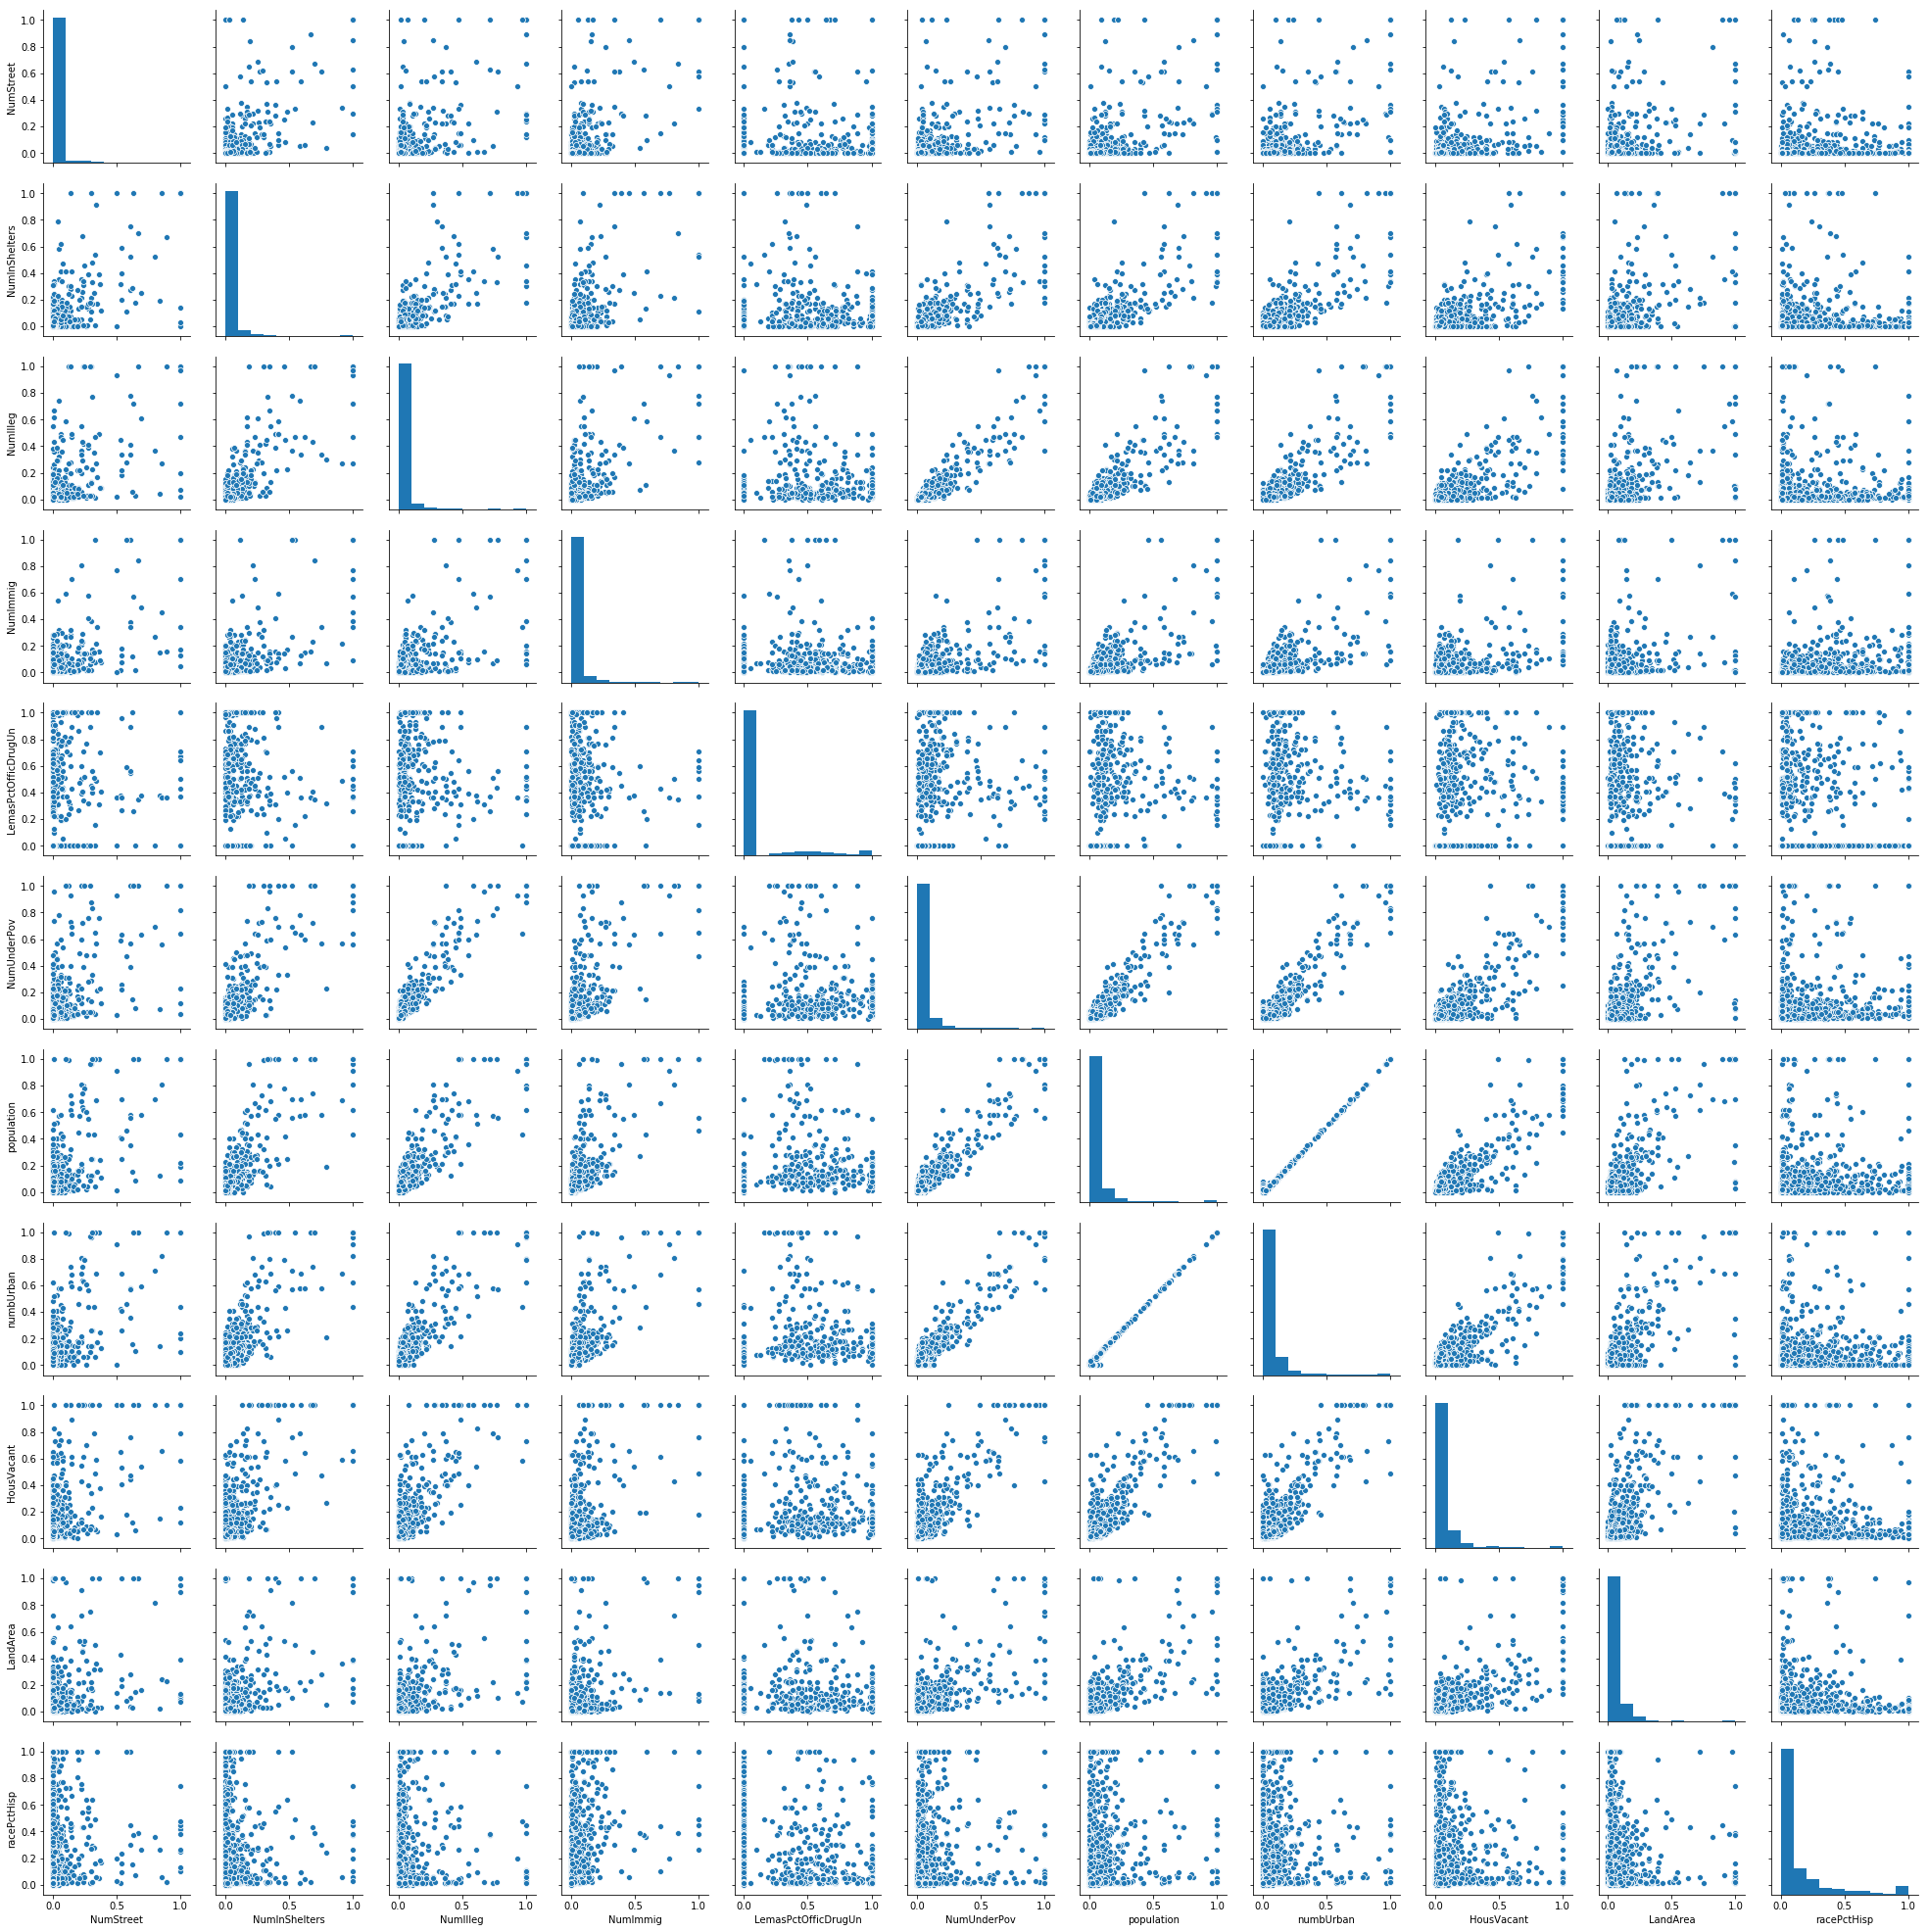

In [10]:
print('------------------------------------------------------------------------')
print('SCATTER PLOT OF 11 FEATURES')
print('------------------------------------------------------------------------')
topN = round(math.sqrt(128))
sortedCVs = sorted(CVList.items(), key=operator.itemgetter(1), reverse=True)
plotData = pd.DataFrame()
for i in range(0, topN):
    featureName = sortedCVs[i][0]
    featureData = communityDataX[featureName]
    plotData = pd.concat([plotData, featureData], axis=1)

sb.pairplot(plotData)

## Findings:
Scatterplot is used to find out correlation/association between two variables. This scatterplot shows a strong, positive linear association between features 'numbUrban' and 'population'. Also, there is a positive association between features 'population' and 'NumUnderPov'. There is a positive correlation between many features.

# Box plot of sqrt(128) features with highest CV.

------------------------------------------------------------------------
BOX PLOT OF 11 FEATURES
------------------------------------------------------------------------


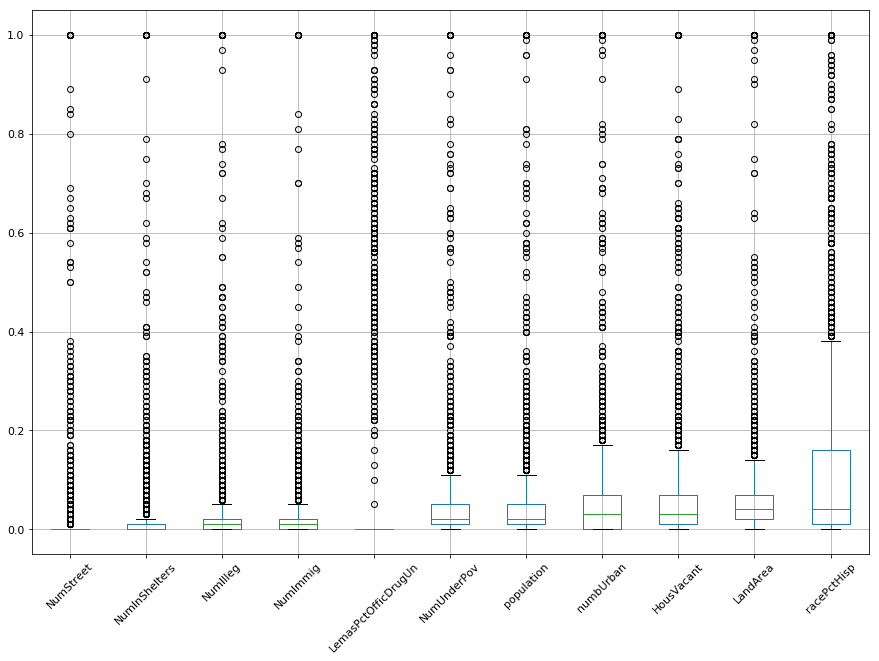

In [11]:
print('------------------------------------------------------------------------')
print('BOX PLOT OF 11 FEATURES')
print('------------------------------------------------------------------------')

plotData.boxplot(rot=45, fontsize=11, figsize=(15, 10))

# Linear Model using Least Squares.

In [12]:
OLSLinearModel = LinearRegression()
OLSLinearModel = OLSLinearModel.fit(communityTrainDataX, communityTrainDataY)

OLSPredictedY = OLSLinearModel.predict(communityTestDataX)
OLSPredictedY = OLSPredictedY.flatten()

actualTestDataY = np.array(communityTestDataY).flatten()

OLSMSE = mean_squared_error(actualTestDataY, OLSPredictedY)
OLSMSE = round(OLSMSE, 3)
print('--------------------------------------------------')
print('TEST MSE FOR OLS REGRESSION:', OLSMSE)
print('--------------------------------------------------')

--------------------------------------------------
TEST MSE FOR OLS REGRESSION: 6.740265011551214e+17
--------------------------------------------------


# Ridge Regression.

In [13]:
alphas = 10**np.linspace(10,-2,100)*0.5

ridgeModel = RidgeCV(alphas=alphas, cv=10)
ridgeModel = ridgeModel.fit(communityTrainDataX, communityTrainDataY) 
ridgeBestAlpha = round(ridgeModel.alpha_, 3)
print('-----------------------------------------')
print('BEST ALPHA FOR RIDGE REGRESSION:', ridgeBestAlpha)
print('-----------------------------------------')

ridgeModel = Ridge(alpha=ridgeBestAlpha)
ridgeModel = ridgeModel.fit(communityTrainDataX, communityTrainDataY) 
ridgePredictedY = ridgeModel.predict(communityTestDataX).flatten()

ridgeMSE = mean_squared_error(actualTestDataY, ridgePredictedY)  
ridgeMSE = round(ridgeMSE, 3)
print('TEST MSE FOR RIDGE REGRESSION:', ridgeMSE)
print('-----------------------------------------')

-----------------------------------------
BEST ALPHA FOR RIDGE REGRESSION: 2.321
-----------------------------------------
TEST MSE FOR RIDGE REGRESSION: 0.018
-----------------------------------------


# Lasso Regression.

In [14]:
alphas = 10**np.linspace(10,-2,100)*0.5

lassoModel = LassoCV(alphas=alphas, cv=10)
lassoModel = lassoModel.fit(communityTrainDataX, np.array(communityTrainDataY).flatten()) 
lassoBestAlpha = round(lassoModel.alpha_, 3)
print('-----------------------------------------')
print('BEST ALPHA FOR LASSO REGRESSION:', lassoBestAlpha)
print('-----------------------------------------')

lassoModel = Lasso(alpha=lassoBestAlpha)
lassoModel = lassoModel.fit(communityTrainDataX, communityTrainDataY) 
lassoPredictedY = lassoModel.predict(communityTestDataX).flatten()
lassoMSE = mean_squared_error(actualTestDataY, lassoPredictedY) 
lassoMSE = round(lassoMSE, 3)
print('TEST MSE FOR LASSO REGRESSION:', lassoMSE)

print('-----------------------------------------')
print('FEATURES SELECTED BY LASSO REGRESSION:')
print('-----------------------------------------')
lassoCoefficients = lassoModel.coef_
tableData = []
for i in range(0, len(lassoCoefficients)):
    if lassoCoefficients[i]!=0:
        row = []
        row.append(features[i])
        tableData.append(row)
tableHeaders = ['Feature Name']
printDatainTable(tableHeaders, tableData)

-----------------------------------------
BEST ALPHA FOR LASSO REGRESSION: 0.005
-----------------------------------------
TEST MSE FOR LASSO REGRESSION: 0.019
-----------------------------------------
FEATURES SELECTED BY LASSO REGRESSION:
-----------------------------------------
+==================+
|   Feature Name   |
+==================+
|   racePctWhite   |
+------------------+
|     pctUrban     |
+------------------+
|  MalePctDivorce  |
+------------------+
|   PctKids2Par    |
+------------------+
|     PctIlleg     |
+------------------+
| PctPersDenseHous |
+------------------+
|    HousVacant    |
+------------------+
| PctVacantBoarded |
+------------------+


# Lasso Regression on Standardized Features.

In [15]:
scaler = preprocessing.StandardScaler()
scaler = scaler.fit(communityDataX)
scaledTrainDataX = scaler.transform(communityTrainDataX)
scaledTestDataX = scaler.transform(communityTestDataX)

alphas = 10**np.linspace(10,-2,100)*0.5

scaledLassoModel = LassoCV(alphas=alphas, cv=10)
scaledLassoModel = scaledLassoModel.fit(scaledTrainDataX, np.array(communityTrainDataY).flatten()) 
scaledLassoBestAlpha = round(scaledLassoModel.alpha_, 3)
print('-----------------------------------------------------------------')
print('BEST ALPHA FOR LASSO REGRESSION:', scaledLassoBestAlpha)
print('-----------------------------------------------------------------')

scaledLassoModel = Lasso(alpha=scaledLassoBestAlpha)
scaledLassoModel = scaledLassoModel.fit(scaledTrainDataX, communityTrainDataY) 
scaledLassoPredictedY = scaledLassoModel.predict(scaledTestDataX).flatten()

scaledLassoMSE = mean_squared_error(actualTestDataY, scaledLassoPredictedY)
scaledLassoMSE = round(scaledLassoMSE, 3)
print('TEST MSE FOR LASSO REGRESSION:', scaledLassoMSE)

print('-----------------------------------------------------------------')
print('FEATURES SELECTED BY LASSO REGRESSION ON STANDARDIZED FEATURES:')
print('-----------------------------------------------------------------')
scaledLassoCoefficients = scaledLassoModel.coef_
tableData = []
for i in range(0, len(scaledLassoCoefficients)):
    if scaledLassoCoefficients[i]!=0:
        row = []
        row.append(features[i])
        tableData.append(row)
tableHeaders = ['Feature Name']
printDatainTable(tableHeaders, tableData)

-----------------------------------------------------------------
BEST ALPHA FOR LASSO REGRESSION: 0.005
-----------------------------------------------------------------
TEST MSE FOR LASSO REGRESSION: 0.017
-----------------------------------------------------------------
FEATURES SELECTED BY LASSO REGRESSION ON STANDARDIZED FEATURES:
-----------------------------------------------------------------
+=======================+
|     Feature Name      |
+=======================+
|     racepctblack      |
+-----------------------+
|     racePctWhite      |
+-----------------------+
|      agePct12t29      |
+-----------------------+
|       pctUrban        |
+-----------------------+
|      pctWInvInc       |
+-----------------------+
|      pctWPubAsst      |
+-----------------------+
|      pctWRetire       |
+-----------------------+
|      AsianPerCap      |
+-----------------------+
|    MalePctDivorce     |
+-----------------------+
|      PctKids2Par      |
+-----------------------

In [16]:
tableData = []
row = []
row.append('Ridge Regression without standardization')
row.append(ridgeMSE)
tableData.append(row)
row = []
row.append('Lasso Regression without standardization')
row.append(lassoMSE)
tableData.append(row)
row = []
row.append('Lasso Regression with standardization')
row.append(scaledLassoMSE)
tableData.append(row)
tableHeaders = ['Model', 'Test MSE']
printDatainTable(tableHeaders, tableData)

+==========================================+==========+
|                  Model                   | Test MSE |
+==========================================+==========+
| Ridge Regression without standardization |  0.018   |
+------------------------------------------+----------+
| Lasso Regression without standardization |  0.019   |
+------------------------------------------+----------+
|  Lasso Regression with standardization   |  0.017   |
+------------------------------------------+----------+


## Findings:
Based on the mean squared error obtained for test data, it can be inferred that standardizing normalized features do not change the MSE much for Lasso regression on normalized features only.

# Principal Component Regression.

In [17]:
PCRErrors = {}
for m in range(1, len(features)+1):
    kFolds = KFold(n_splits=10, shuffle=False)
    npTrainDataX = np.array(communityTrainDataX)
    npTrainDataY = np.array(communityTrainDataY)
    cvError = []
    for trainIdx, valIdx in kFolds.split(npTrainDataX, npTrainDataY):
        # Get training data
        trainX = []
        trainY = []
        for idx in trainIdx:
            trainX.append(communityTrainDataX.iloc[idx]) 
            trainY.append(communityTrainDataY.iloc[idx]) 
        trainX = pd.DataFrame(trainX, columns=features)
        trainY = pd.DataFrame(trainY, columns=[response])
        
        # Get validation data
        valX = []
        valY = []
        for idx in valIdx:
            valX.append(communityTrainDataX.iloc[idx]) 
            valY.append(communityTrainDataY.iloc[idx]) 
        valX = pd.DataFrame(valX, columns=features)
        valY = pd.DataFrame(valY, columns=[response])
        
        # Find m principal components
        pca = PCA(n_components=m)
        pca = pca.fit(trainX)
        newTrainX = pca.transform(trainX)
        newValX = pca.transform(valX)
        
        pcrModel = LinearRegression()
        pcrModel = pcrModel.fit(newTrainX, trainY)
        cvPredictedY = pcrModel.predict(newValX).flatten()
        actualValY = np.array(valY).flatten()
        err = mean_squared_error(actualValY, cvPredictedY)  
        err = round(err, 3)
        cvError.append(err)
    PCRErrors[m] = np.mean(cvError)

print('-------------------------------------------------------------------')
print('CROSS-VALIDATION MSE FOR DIFFERENT NUMBER OF PRINCIPAL COMPONENTS')
print('-------------------------------------------------------------------')
tableData = []
for k,v in PCRErrors.items():
    row = []
    row.append(k)
    row.append(round(v, 3))
    tableData.append(row)
tableHeaders = ['M', 'Cross-Validation MSE']
printDatainTable(tableHeaders, tableData)

-------------------------------------------------------------------
CROSS-VALIDATION MSE FOR DIFFERENT NUMBER OF PRINCIPAL COMPONENTS
-------------------------------------------------------------------
+=====+======================+
|  M  | Cross-Validation MSE |
+=====+======================+
|  1  |        0.038         |
+-----+----------------------+
|  2  |        0.031         |
+-----+----------------------+
|  3  |        0.028         |
+-----+----------------------+
|  4  |        0.024         |
+-----+----------------------+
|  5  |        0.023         |
+-----+----------------------+
|  6  |        0.023         |
+-----+----------------------+
|  7  |         0.02         |
+-----+----------------------+
|  8  |         0.02         |
+-----+----------------------+
|  9  |         0.02         |
+-----+----------------------+
| 10  |         0.02         |
+-----+----------------------+
| 11  |         0.02         |
+-----+----------------------+
| 12  |         0.02   

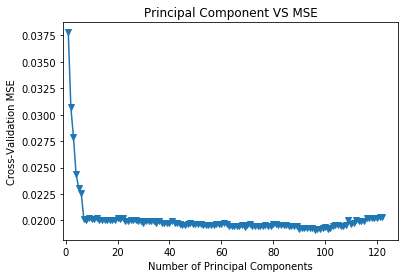

In [18]:
plt.plot(PCRErrors.keys(), PCRErrors.values(), '-v')
plt.xlabel('Number of Principal Components')
plt.xlim(left=-1)
plt.ylabel('Cross-Validation MSE')
plt.title('Principal Component VS MSE')
plt.show()

In [19]:
sortedErrors = sorted(PCRErrors.items(), key=operator.itemgetter(1))
bestM = sortedErrors[0][0]
print('----------------------')
print('BEST M:', bestM)
print('----------------------')

----------------------
BEST M: 96
----------------------


In [20]:
finalPCA = PCA(n_components=bestM)
finalPCA = finalPCA.fit(communityTrainDataX)
pcaTrainDataX = finalPCA.transform(communityTrainDataX)
pcaTestDataX = finalPCA.transform(communityTestDataX)

finalPCRModel = LinearRegression()
finalPCRModel = finalPCRModel.fit(pcaTrainDataX, communityTrainDataY)

finalPCRPredictedY = finalPCRModel.predict(pcaTestDataX).flatten()

finalPCRMSE = mean_squared_error(actualTestDataY, finalPCRPredictedY)  
finalPCRMSE = round(finalPCRMSE, 3)
print('---------------------------------------------------------')
print('TEST MSE FOR PRINCIPAL COMPONENT REGRESSION:', finalPCRMSE)
print('---------------------------------------------------------')

---------------------------------------------------------
TEST MSE FOR PRINCIPAL COMPONENT REGRESSION: 0.018
---------------------------------------------------------


# L1-Penalized Gradient Boosting Tree.

In [21]:
numpyTrainX = np.array(communityTrainDataX)
numpyTrainY = np.array(communityTrainDataY)

# Select best alpha for XGBoost
xgbModel = xgb.XGBRegressor(objective='reg:squarederror')
xgbParameters = {'reg_alpha': alphas}
xgbModelValidation = GridSearchCV(xgbModel, xgbParameters, cv=10)
xgbModelValidation = xgbModelValidation.fit(numpyTrainX, numpyTrainY.flatten())

xgbBestAlpha = xgbModelValidation.best_params_['reg_alpha']
xgbBestAlpha = round(xgbBestAlpha, 3)
print('---------------------------------------------------------')
print('BEST ALPHA FOR XGBOOST:', xgbBestAlpha)

# Fit XGBoost on best alpha selected
finalXGBModel = xgb.XGBRegressor(objective='reg:squarederror', reg_alpha=xgbBestAlpha)
finalXGBModel = finalXGBModel.fit(numpyTrainX, numpyTrainY)

numpyTestX = np.array(communityTestDataX)

xgboostPredictedY = finalXGBModel.predict(numpyTestX)
xgboostMSE = mean_squared_error(actualTestDataY, xgboostPredictedY)
xgboostMSE = round(xgboostMSE, 3)
print('---------------------------------------------------------')
print('TEST MSE FOR XGBOOST REGRESSION:', xgboostMSE)
print('---------------------------------------------------------')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


---------------------------------------------------------
BEST ALPHA FOR XGBOOST: 0.249
---------------------------------------------------------
TEST MSE FOR XGBOOST REGRESSION: 0.017
---------------------------------------------------------
